SA2VA
====

**Sa2VA: Marrying SAM2 with LLaVA for Dense Grounded Understanding of Images and Videos**

![SA2VA model](../assets/sa2va_overview.jpg)

```bash
pip install torch torchvision
pip install transformers

pip install einops flash_attn
pip install timm
```

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from PIL import Image
import numpy as np
import os

# load the model and tokenizer
path = "ByteDance/Sa2VA-1B"
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device);

/home/pyml/anaconda3/envs/py311/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Image-based QA

In [3]:
image_path = "../samples/plants.jpg"
text_prompts = "<image>Please describe the image."
image = Image.open(image_path).convert('RGB')
input_dict = {
    'image': image,
    'text': text_prompts,
    'past_text': '',
    'mask_prompts': None,
    'tokenizer': tokenizer,
    }
return_dict = model.predict_forward(**input_dict)
answer = return_dict["prediction"] # the text format answer
print(answer)


`generation_config` default values have been modified to match model-specific defaults: {'bos_token_id': 151643}. If this is not desired, please set these values explicitly.


The image features two potted plants placed side by side on a wooden floor. The plants are in gold-colored pots, and they are positioned in front of a white wall. The pots are made of metal and have a unique design, with one pot having a black base and the other having a gold base. The floor is made of wood, and the overall scene is well-lit.<|im_end|>


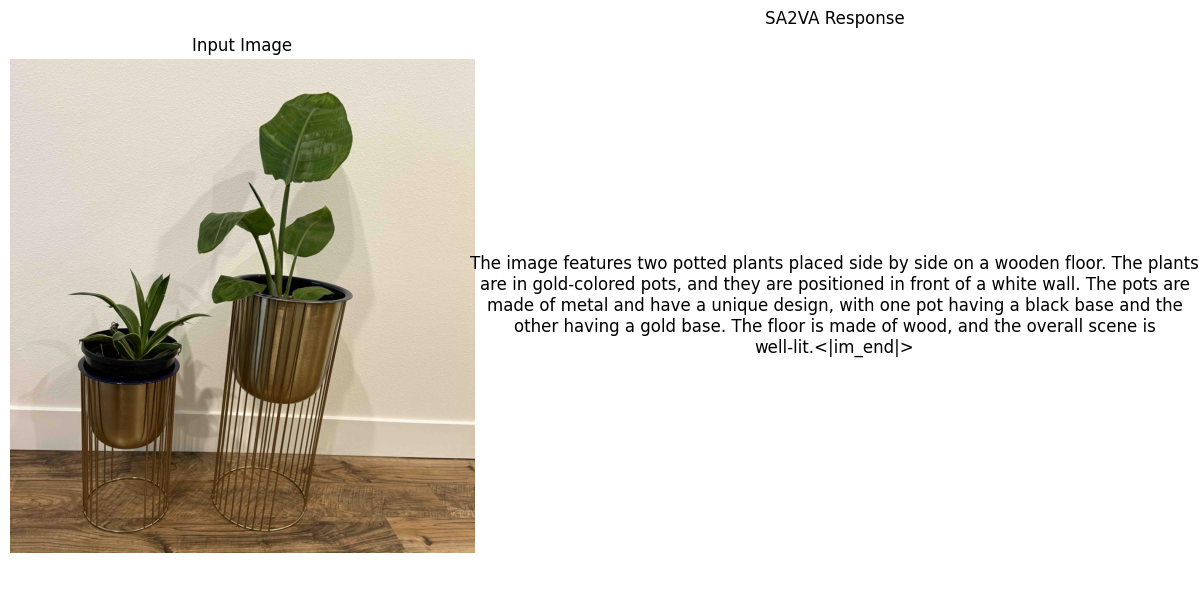

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title("Input Image")
axes[1].text(
    0.5, 0.5, answer,
    fontsize=12, ha="center", va="center", wrap=True
)
axes[1].axis("off")
axes[1].set_title("SA2VA Response")
plt.tight_layout()
plt.show()

### VQA with segmentation output

In [10]:
text_prompts = (
    "<image>Could you please give me a brief description "
    "of the image? Please respond with interleaved segmentation"
    "masks for the corresponding parts of the answer."
)
image = Image.open(image_path).convert('RGB')
input_dict = {
    'image': image,
    'text': text_prompts,
    'past_text': '',
    'mask_prompts': None,
    'tokenizer': tokenizer,
    }
return_dict = model.predict_forward(**input_dict)
answer = return_dict["prediction"]
masks = return_dict['prediction_masks']
print("output masks shape:", len(masks), masks[0].shape)
print(answer)

output masks shape: 3 (1, 1137, 1068)
The image features two potted plants, <p> potted plant-1 </p> [SEG] and <p> potted plant-2 </p> [SEG], placed on a wooden floor. They are positioned in front of a <p> wall </p> [SEG].<|im_end|>


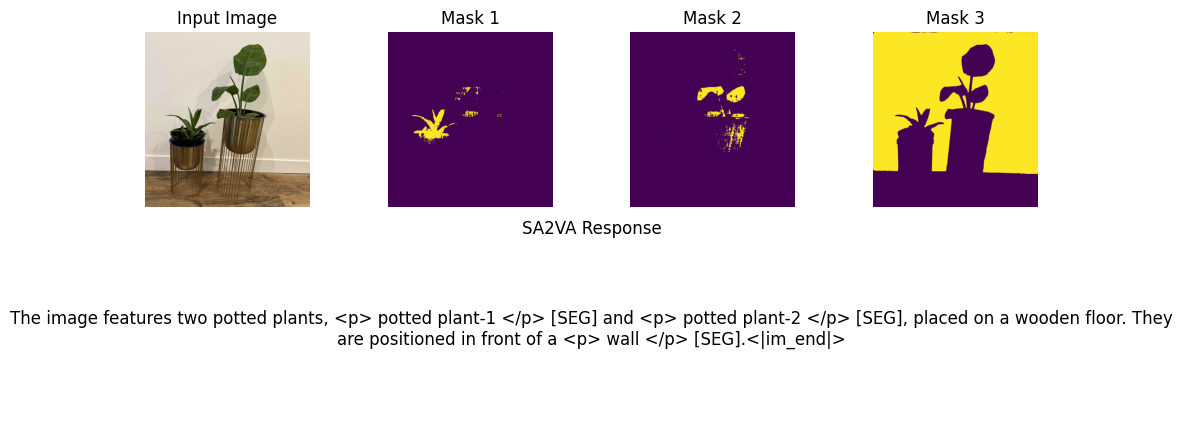

In [ ]:
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 4)
# the first row
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(image)
ax1.axis("off")
ax1.set_title("Input Image")

# the masks
for i, mask in enumerate(masks):
    ax = fig.add_subplot(gs[0, i + 1])
    ax.imshow(mask[0])
    ax.axis("off")
    ax.set_title(f"Mask {i + 1}")

# the second row
ax2 = fig.add_subplot(gs[1, :])
ax2.text(
    0.5, 0.5, answer,
    fontsize=12, ha="center", va="center", wrap=True
)
ax2.axis("off")
ax2.set_title("SA2VA Response")
plt.show()